In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
import torchvision
from torchvision.transforms import InterpolationMode
from torchvision.models import vit_b_16, ViT_B_16_Weights
from PIL import ImageFile

warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

torch.backends.cudnn.benchmark = True

print(torchvision.__version__)



Using device: cuda
0.20.1


In [2]:
base_dir = "D:/Project/Action/processed_dataset"

image_size = 224
batch_size = 16
num_workers = 4

# 전처리 정의 (EfficientNet 공식 전처리 참고)
transform = transforms.Compose([
    transforms.Resize((image_size, image_size), interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # 기본 정규화 (or ImageNet 기준 변경 가능)
])

In [3]:
train_dataset = datasets.ImageFolder(os.path.join(base_dir, "train"), transform=transform)
val_dataset   = datasets.ImageFolder(os.path.join(base_dir, "val"), transform=transform)
test_dataset  = datasets.ImageFolder(os.path.join(base_dir, "test"), transform=transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=num_workers)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=num_workers)

print("Dataset loaded")
print(f"  - Train: {len(train_dataset)}")
print(f"  - Val:   {len(val_dataset)}")
print(f"  - Test:  {len(test_dataset)}")
print(f"  - Classes: {train_dataset.classes}")

Dataset loaded
  - Train: 4979
  - Val:   3172
  - Test:  3444
  - Classes: ['걷거나 달리는 동작', '그루밍하는 동작', '꼬리를 흔드는 동작', '납작 엎드리는 동작', '머리를 들이대는 동작', '발을 숨기고 웅크리고 앉는 동작', '배를 보여주는 동작', '앞발로 꾹꾹 누르는 동작', '옆으로 눕는 동작', '좌우로 뒹구는 동작', '팔을 뻗어 휘적거리는 동작', '허리를 아치로 세우는 동작']


In [5]:
weights = ViT_B_16_Weights.DEFAULT
model = vit_b_16(weights=weights)

# 출력 클래스 수 정의
num_classes = len(train_dataset.classes)

model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)

# 모델을 GPU로 이동
model = model.to(device)

# 확인
print("ViT-B/16 model loaded")
print(model.heads.head)


ViT-B/16 model loaded
Linear(in_features=768, out_features=12, bias=True)


In [6]:
# 손실 함수 (CrossEntropyLoss for multi-class classification)
criterion = nn.CrossEntropyLoss()

# 옵티마이저 (Adam 사용)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# 학습률 스케줄러 (epoch마다 학습률 감소)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

print("Criterion, Optimizer, Scheduler are set.")


Criterion, Optimizer, Scheduler are set.


In [7]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
torch.backends.cudnn.benchmark = True


In [8]:
num_epochs = 10

train_losses, val_losses = [], []
val_accuracies          = []
lr_history              = []

for epoch in range(num_epochs):
    # Train
    model.train()
    running_loss = 0.0
    n_train_batches = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        try:
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            n_train_batches += 1
        except RuntimeError as e:
            if "out of memory" in str(e):
                print("OOM → train batch skipped")
                torch.cuda.empty_cache()
                continue
            else:
                raise

    scheduler.step()
    lr_history.append(optimizer.param_groups[0]["lr"])
    avg_train_loss = running_loss / n_train_batches
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_running_loss = 0.0
    n_val_batches    = 0
    correct, total   = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            try:
                outputs = model(images)
                loss = criterion(outputs, labels)          # ← val loss
                val_running_loss += loss.item()
                n_val_batches += 1

                _, predicted = torch.max(outputs, 1)
                total   += labels.size(0)
                correct += (predicted == labels).sum().item()
            except RuntimeError as e:
                if "out of memory" in str(e):
                    print("OOM (val) → batch skipped")
                    torch.cuda.empty_cache()
                    continue
                else:
                    raise

    avg_val_loss = val_running_loss / n_val_batches
    val_losses.append(avg_val_loss)

    val_acc = 100 * correct / total
    val_accuracies.append(val_acc)

    # Epoch log
    print(f"Epoch [{epoch+1}/{num_epochs}]  "
          f"Train Loss: {avg_train_loss:.4f}  "
          f"Val Loss: {avg_val_loss:.4f}  "
          f"Val Acc: {val_acc:.2f}%  "
          f"LR: {lr_history[-1]:.6f}")


Epoch [1/10]  Train Loss: 0.6947  Val Loss: 0.3470  Val Acc: 91.20%  LR: 0.000100
Epoch [2/10]  Train Loss: 0.0815  Val Loss: 0.3112  Val Acc: 90.98%  LR: 0.000100
Epoch [3/10]  Train Loss: 0.0570  Val Loss: 0.2836  Val Acc: 92.18%  LR: 0.000050
Epoch [4/10]  Train Loss: 0.0110  Val Loss: 0.1730  Val Acc: 95.30%  LR: 0.000050
Epoch [5/10]  Train Loss: 0.0015  Val Loss: 0.1697  Val Acc: 95.62%  LR: 0.000050
Epoch [6/10]  Train Loss: 0.0008  Val Loss: 0.1724  Val Acc: 95.65%  LR: 0.000025
Epoch [7/10]  Train Loss: 0.0007  Val Loss: 0.1736  Val Acc: 95.65%  LR: 0.000025
Epoch [8/10]  Train Loss: 0.0006  Val Loss: 0.1752  Val Acc: 95.62%  LR: 0.000025
Epoch [9/10]  Train Loss: 0.0005  Val Loss: 0.1773  Val Acc: 95.68%  LR: 0.000013
Epoch [10/10]  Train Loss: 0.0005  Val Loss: 0.1782  Val Acc: 95.65%  LR: 0.000013


In [11]:
from sklearn.metrics import f1_score

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")

f1_micro = f1_score(all_labels, all_preds, average='micro')
print(f"F1 Score (Micro):    {f1_micro:.4f}")

Test Accuracy: 96.11%
F1 Score (Micro):    0.9611


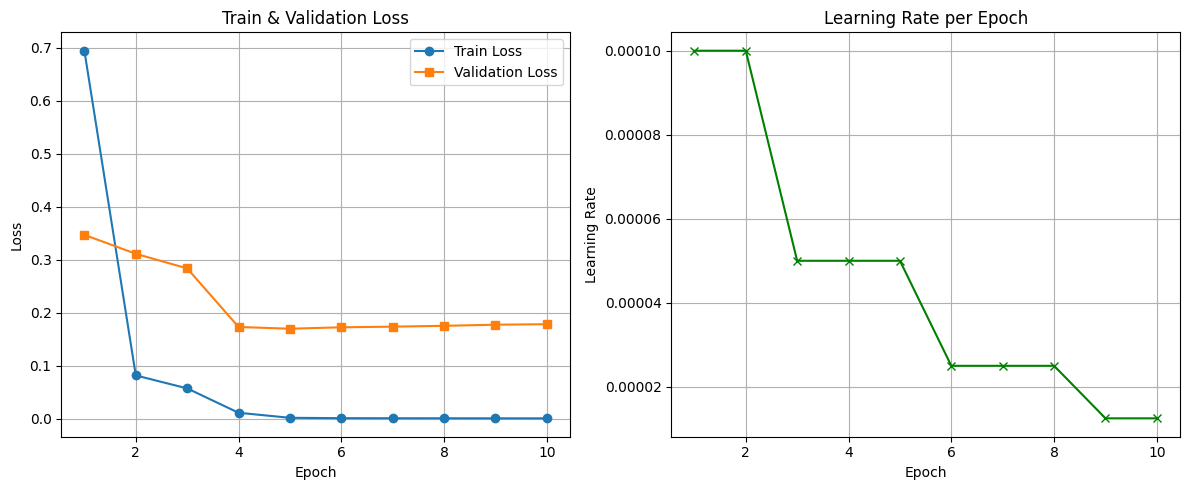

In [9]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Train / Val Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='s')
plt.title("Train & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Learning Rate 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, lr_history, label='Learning Rate', color='green', marker='x')
plt.title("Learning Rate per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.grid(True)

plt.tight_layout()
plt.show()


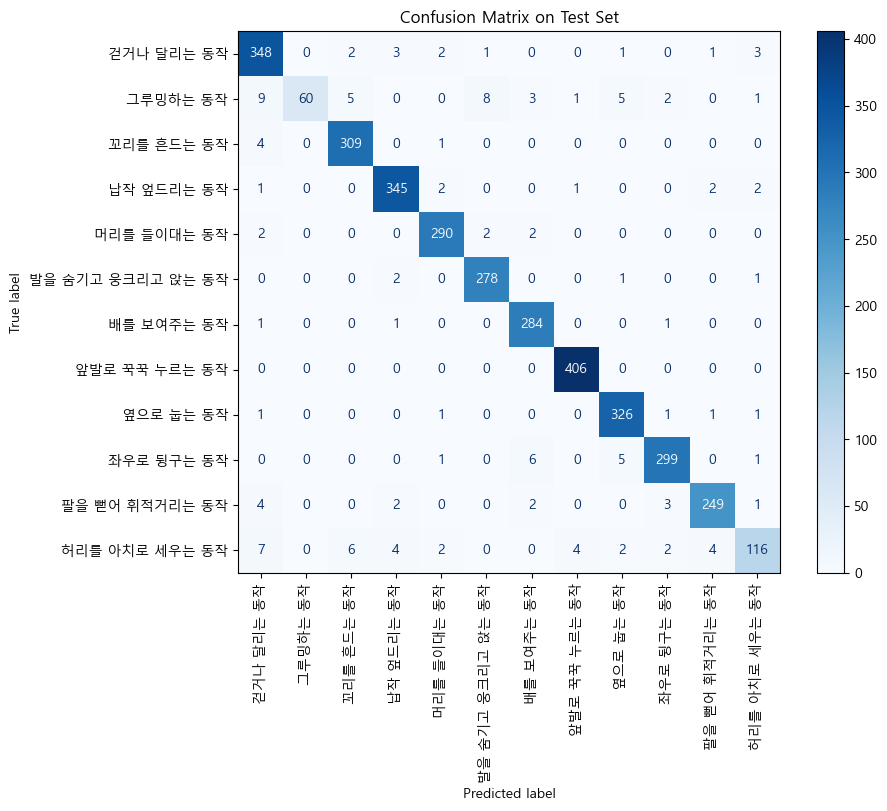

In [10]:
# Confusion Matrix
from matplotlib import font_manager, rc

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

class_names = test_dataset.classes

font_path = "C:/Windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

cm = confusion_matrix(all_labels, all_preds)

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', ax=ax, xticks_rotation=90)
plt.tight_layout()
plt.title("Confusion Matrix on Test Set")
plt.show()

In [13]:
torch.save(model.state_dict(), "ViT-B_16_Action.pt")
print("모델 저장 완료: ViT-B/16_Action.pt")


모델 저장 완료: ViT-B/16_Action.pt
